In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#download data from yahoo finance
import yfinance as yf
df = yf.download('GOOGL',start='2010-10-10',end='2020-2-20',progress=False, actions='inline')

df.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-10-11,269.509521,272.572571,268.853851,269.689697,269.689697,5247347,0,0.0
2010-10-12,270.330322,273.268280,269.164154,270.965973,270.965973,7499693,0,0.0
2010-10-13,273.773773,274.019012,271.436432,271.921936,271.921936,6105089,0,0.0
2010-10-14,272.362366,272.897888,268.823822,270.735748,270.735748,13254932,0,0.0
2010-10-15,299.934937,301.121124,296.096100,301.026031,301.026031,29619950,0,0.0


In [ ]:
df = df.loc[:,['Adj Close']]
df.rename(columns = {'Adj Close':'adj_close'},inplace = True)

df['simple_rtn'] = df.adj_close.pct_change() #simple return
df['log_rtn'] = np.log(df.adj_close/df.adj_close.shift(1)) #log return

df.head()

,adj_close,simple_rtn,log_rtn
Date,,,
2010-10-11,269.689697,NaN,NaN
2010-10-12,270.965973,0.004732,0.004721
2010-10-13,271.921936,0.003528,0.003522
2010-10-14,270.735748,-0.004362,-0.004372
2010-10-15,301.026031,0.111881,0.106053


In [ ]:
#historical volatility
def realized_volatility(x):
    return np.sqrt(np.sum(x**2))

df_rv = df.groupby(pd.Grouper(freq='M')).apply(realized_volatility)
df_rv.rename(columns={'log_rtn': 'rv'}, inplace=True)

df_rv.rv = df_rv.rv * np.sqrt(12)
df_rv.head()

,adj_close,simple_rtn,rv
Date,,,
2010-10-31,1152.825934,0.117225,0.386622
2010-11-30,1381.450001,0.069207,0.242387
2010-12-31,1388.937831,0.035342,0.121833
2011-01-31,1377.743793,0.054701,0.189706
2011-02-28,1345.796052,0.042067,0.146694


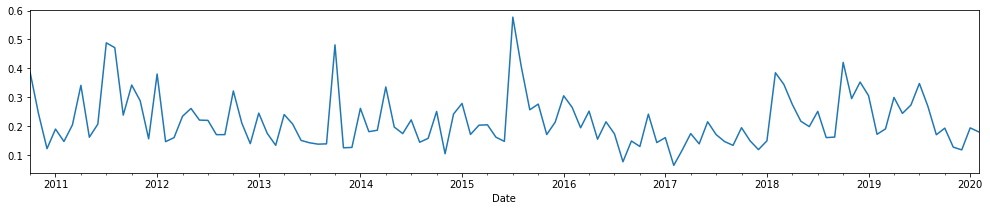

In [ ]:
df_rv.rv.plot(figsize=(17,3))

[Text(0, 0.5, 'Log returns (%)'), Text(0.5, 0, 'Date')]

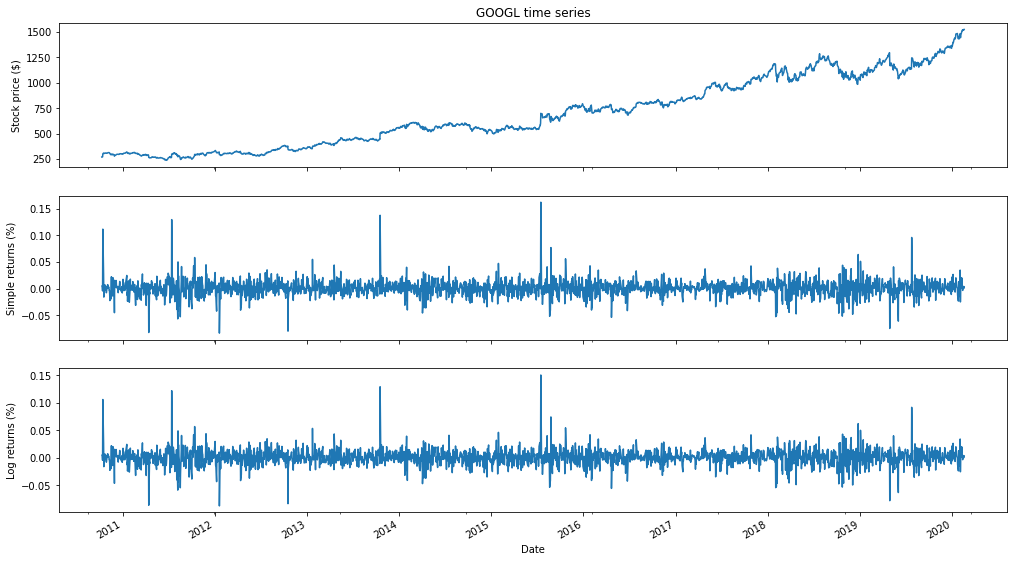

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(17, 10), sharex=True)
df.adj_close.plot(ax=ax[0])
ax[0].set(title = 'GOOGL time series', ylabel = 'Stock price ($)')
df.simple_rtn.plot(ax=ax[1])
ax[1].set(ylabel = 'Simple returns (%)')
df.log_rtn.plot(ax=ax[2])
ax[2].set(xlabel = 'Date',ylabel = 'Log returns (%)')

In [ ]:
#Calculate moving average and moving standard deviation
df_rolling = df[['simple_rtn']].rolling(window=21).agg(['mean', 'std'])

df_rolling.columns = df_rolling.columns.droplevel()

df_outliers = df.join(df_rolling)

In [ ]:
def indentify_outliers(row, n_sigmas=3):
     x = row['simple_rtn']
     mu = row['mean']
     sigma = row['std']
     if (x > mu + 3 * sigma) | (x < mu - 3 * sigma):
         return 1
     else:
         return 0
        
df_outliers['outlier'] = df_outliers.apply(indentify_outliers,axis=1)
outliers = df_outliers.loc[df_outliers['outlier'] == 1,['simple_rtn']]

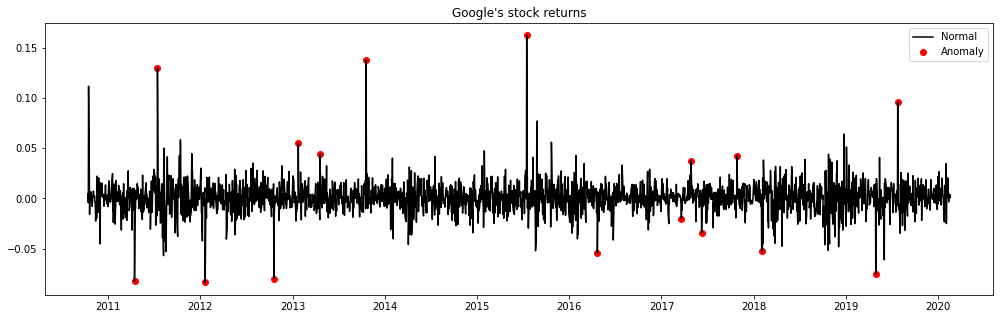

In [ ]:
fig, ax = plt.subplots(figsize=(17,5))
ax.plot(df_outliers.index, df_outliers.simple_rtn, color='black', label='Normal')
ax.scatter(outliers.index, outliers.simple_rtn, color='red', label='Anomaly')
ax.set_title("Google's stock returns")
ax.legend(loc='upper right')